<a href="https://colab.research.google.com/github/pfescriva/Applied-AI-for-Business-Insight/blob/main/TFM_Pere_27_23h.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Fijo 

# Nueva sección

In [ ]:
# !pip install spellchecker
# !pip install indexer

# !python3 -m pip install indexer

# import indexer
# import spellchecker




In [ ]:
from spellchecker import SpellChecker

In [ ]:
# Code to load libraries:

!pip install mglearn
!pip install gensim
!pip install stop_words
!pip install pyLDAvis
!pip install langdetect
!pip install unidecode
!pip install pyspellchecker
!pip install swifter

from spellchecker import SpellChecker # You need to install pyspellchecker and not spellchecker
import sklearn as sk
import pandas as pd 
import numpy as np 
import mglearn
from stop_words import get_stop_words
import nltk, re, string, collections
from nltk.util import ngrams # function for making ngrams
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
import pyLDAvis
import pyLDAvis.sklearn
import warnings
from gensim.utils import simple_preprocess
from gensim import utils 
from collections import Counter
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
from langdetect import detect
import spacy
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd

# Better computational efficiency for loops (apply, list compressions, for, while, etc.)
# import swifter


In [ ]:
# !pip install spellchecker
data

In [ ]:

path = '/content/drive/MyDrive/TFM data/urjc.jsonl.gz'
data = pd.read_json(path, lines = True)


In [ ]:

import swifter

# 0. Some initial cleaning (Empty cols and constant cols)
data.dropna(how = 'all', axis = 1, inplace = True) # Drop empty columns
data = data.loc[:, (data != data.iloc[0]).any()]  # Drop Constant columns
print(data.shape[0])

data = data[data['in_reply_to_user_id'].isnull()]

# Filter out non-spanish documents
data = data.loc[(data['lang'] == "es")].reset_index(drop  = True)
print('First lang filter: ' + str(data.shape[0]))

# Keep only non RT information
data = data.loc[ ~ (data['text'].str.startswith('RT '))]
print('RT removal: ' + str(data.shape[0]))

# 1. Drop duplicated documents that are writen by the same user, and laso drop any tweet that is NA (There were not anyway)
data = data.drop_duplicates(subset = ['author_id', 'text'], keep = 'first', inplace = False, ignore_index = False).reset_index(drop = True)
data = data.dropna(subset = ['text'])
print('Dropped duplicates and empty texts: ' + str(data.shape[0]))

# Filter out non-spanish documents with higher precission.
data['Language'] = data['text'].swifter.apply(detect)
data = data.loc[(data['Language'] == "es")].reset_index(drop  = True)
print('First lang filter: ' + str(data.shape[0]))



In [ ]:
# data = pd.read_pickle("/content/drive/MyDrive/TFM data/clean_data.pkl")

install --upgrade pandas==1.3.1rc0

# LDA with text correction

## Processing

In [ ]:

"""

PRE-PROCESS: 

0. Get the unduplicated / non-retweeted tweets. 


NON-TUNED PRE-PROCESSING STEPS:

1. Remove the hashtags, links and shares

2. Lowcase 

3. Remove punctuation 

4. Remove accents 

5. Remove numbers (TBC)

6. Lemmatise 

7. Make some corrections uncovered above


TUNED STEPS:

8. Remove stopwords (TBC properly) 

9. Remove short tweets 

10. Group by author and gridsearch best LDA hyperparameters.  

"""


import warnings
warnings.filterwarnings("ignore")


# 1. Remove links, hashtags and mentions
# --------------------------------------

def hashtag(txt):
    
    # Remove hashtags
    result = ' '.join(word for word in txt.split(' ') if not word.startswith('#'))
    
    # Remove shares
    result = ' '.join(word for word in result.split(' ') if not word.startswith('@'))
    # check if this doesn't work well use: result = re.sub(r'@\S+', '', result)
        
    # Remove some jajajas
    result = ' '.join(word for word in result.split(' ') if 'jaja' not in word.lower())
    result = ' '.join(word for word in result.split(' ') if 'jj' not in word.lower())
    result = ' '.join(word for word in result.split(' ') if 'haha' not in word.lower())

    # Remove links
    result = re.sub(r'http\S+', '', result)

    # Further work with potential remainings
    result = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", result)
    result = re.sub(r'[¿“‘?’"„“<>,!"]', "", result)
    result = re.sub('!', "", result)
    
    return result

    
data['text'] = data['text'].apply(hashtag)


# 2. Lowcase and make corrections
# --------------------------------------

data['text'] = data['text'].apply(np.char.lower)



# 3. Remove punctuation from text
# --------------------------------------

from gensim.parsing.preprocessing import strip_punctuation
data['text'] = data['text'].apply(strip_punctuation)



# 4. Correct some misspallings and Remove accents from text
# --------------------------------------


# It take some time: 200 rows per minute 
data = data[data['text'].map(len) > 2]

def correction(x): 

    # spanish = SpellChecker(language = 'es')  # use the Spanish Dictionary
    
    """
    correction(x) process: 
    1. Convert string into list of words
    2. Apply the most likely correction of each word
    3. Convert the list back to a string
    """
    
    x = x.split()
    x = [spanish.correction(word) for word in x]
    x = ' '.join([word for word in x])
    
    return x

spanish = SpellChecker(language = 'es')  # use the Spanish Dictionary    
data['correction'] = data['text'].swifter.apply(correction)
 


KeyboardInterrupt: ignored

In [ ]:


# data = pd.read_pickle("/content/drive/MyDrive/TFM data/data_with_corrections.pkl")


# 5. Remove numbers
# --------------------------------------
data['text'] = data['correction'].str.replace('\d+', '')


# 6. Further cleaning before lemmatisation
# --------------------------------------
def corrector(text):     
    text = text.replace(' lumnos ', ' alumno ') 
    text = text.replace(' estudiante ', ' alumno ') # Synonims I think it's worth having them as the same word
    text = text.replace(' avda ', ' avenida ')
    text = text.replace(' info ', ' informacion ')
    text = text.replace(' uni ', ' universidad ')
    text = text.replace(' almerio ', ' almeria ')
    text = text.replace(' estudio ', ' estudiar ')
    text = text.replace(' cambier ', ' cambiar ')
    text = text.replace(' como ', '')
    text = text.replace(' para ', '')
    text = text.replace(' parte ', '')
    text = text.replace(' sobre ', '')
    text = text.replace(' del ', '')
    text = text.replace(' nada ', '')
    
    return text

data['text'] = data['text'].swifter.apply(corrector)


# 7. Lemmatisation
# --------------------------------------
# The purpose of this code is to lemmatize (Convert to dictionary form) the words in each document, keeping the same format

# You need to run the code below before in order to be able to load es_core_news_sm.
# !python -m spacy download es_core_news_sm
# nlp = spacy.load('es_core_news_sm', exclude = ['derechos', 'expres', 'ademas', 'traves', 'adios', 'para', 'casar'], 
#                  disable = ['derechos', 'expres', 'ademas', 'traves', 'adios', 'para', 'casar'])

!python -m spacy download es
nlp = spacy.load('es')

def lemmatizer(text):  
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc])

data['lemmatized'] = data['text'].swifter.apply(lambda x: lemmatizer(x)) 


from gensim.parsing.preprocessing import strip_multiple_whitespaces
data['lemmatized'] = data['lemmatized'].apply(strip_multiple_whitespaces)

import unidecode
data['lemmatized'] = data['lemmatized'].apply(unidecode.unidecode)
data['lemmatized'] = data['lemmatized'].apply(gensim.utils.deaccent) # In case we apply both

# Be aware of the words that would change with lematization: titulo, grado, 

# 8. Stopwords work 
# --------------------------------------

# Find the list of stopwords

# Note that the removal depends on the library and will be part of each. 
stop_words = stopwords.words('spanish')
stop_words_extension = get_stop_words('es')
stop_words.extend(stop_words_extension)

# Remove accents from stopwords (I'll work with no accents anywhere, since we don't expect people to write always with accents) 
stop_words = [gensim.utils.deaccent(each_word) for each_word in stop_words]

stop_words.extend(['urgir', 'do', 'interesante', 'universidadjuancarlos', 'él', 'hala', 'juanca', 'reyjuancar', 'urjcritica', 'this', 'was', 'date', 'great', 'my', 'first', 'claro', 'queydondeestudiar2020', 'rey', 'juan', 'literalmente', 'universidadreyjuancarlo', 'universidadjuancarlos', 'lareyjuancarlos', 'universidadreyjuancarlos', 'universidadreyjuancarlo', 'urjc', 'gracia', 'gracias','ajjaj', 'xd', 'xdd', 'xdxd', 'Madrid', 'primero', 'segundo', 'tercero', 'cuarto', 'quinto', 'sexto', 'septimo', 'octavo', 't', 'a', 's', 'k', 'q', 'mas', 'tambien', 'ir', 'alla', 'cosa', 'iee', 'siquiera', 'in', 'the', 'of', 'ano', 'n', 'p', 'r', 'asi', 'coincidir', 'aa', 'decir', '¡', '¿', 'poder', 'podeis', 'estais', 'traves', 'alguno', 'buen', 'nosotrxs', 'bufff', 'buff', 'universitario', 'lol', 'omg', 'wtf', 'idk', 'fyi', 'tbh', 'lmao', 'asap', 'thanks', 'thank', 'thx', 
                'trav', 'bastante', 'muchisimo', 'muchisimos', 'muchisima', 'muchisimas', 'muchisimar', 'monton', 'habia', 'xe', 'jo', 'ops', 'ups', 'yupi', 'poca', 'poco', 'enhorabuena', 'incluso', 'igual', 'ahora', 'despu', 'pese', 'ser', 'cierto', 'haber', 'for', 'par', 'universidad', 'with', 'asimismo', 'carlos', 'universidad', 'iii', 'ser', 'entonces', 'madrid', 'tras', 'jo él', 'hacer', 'espán', 'noticia', 'as', 'periodico', 'diario', 'news', 'si', 'aca', 'mas', 'ademas', 'gracias', 'aqui', 'hola', 'saludos', 'hoy', 'co', 'bien', 'ver', 'dar', 'vosotrxs', 'wow', 'ahora', 'solo', 'todo', 'cualquier', 'cualquiera', 'pues', 'vez', 'mismo', 'evidentemente', 'uee', 'hey', 'hello', 'xvii', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', 'xii', 'xiii', 'xiv', 'xv', 'xvi', 'xviii', 'ixx', 'xx', 'xxi', 
                'parte', 'normalmente', 'mil', 'adio', 'millon', '!', 'yosoyurjc', 'haced', 'hacerte', 'mientras', 'menos', 'después', 'despues', 'dias', 'cuyo', 'cuya', 'of', '_', 'aun', 'nunca', 'siempre', 'muchisima', 'dia', 'algun', 'pon', 'sino', 'mejor', 'poca', 'peor', 'ano', 'nuevo', '200', '-', 'uee', 'href', 'uno', 'dos', 'tres', 'espán', 'medal él', 'desmontar él', 'jo él', 'joder', 'char él', 'queydondeestudiar', 'mer él', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez', 'veintena', 'doce', 'docena', 'trece', 'veitiuno', 'cien', 'decena', 'x2', '–', 'https', 'http', 'rt', 'm', 'uc', 'alguien', 'cada', 'latest', 'tmb', 'via', 'tal', 'etc', 'etcetera', 'traves', 'ma', 'ahi', 'aqui', 'alli', 'alla', 'so', 'if', 'mmm', 'hmm', 'ja', 'cuidadosamente', 'quizas', 'quiza', 'nada', 'nunca', 'probablemente', 'mismisimo', 'totalmente', 'completamente'])

stop_words.extend(['informacion', 'titulo', 'alumno', 'estudiar', 'profesor', 'primerisimo', 'adema', 'yomequedoencasa'])

# Frequent words that add litle meaning: Hyperparameter in gridsearch
# puto, cuenta-contar, bueno, mostoles, cursar-curso, nada (transformed to nadar...), volver,
extras = ['seguro', 'cursar', 'bueno', 'realizar', 'titulo', 'clase', 'tener', 'necesitar', 'querer', 'abrir', 'agarrar', 'andar', 'caminar', 'buscar', 'caer', 'conocer', 'saber', 'hablar', 'tener', 'tomar', 'poner', 'dar', 'ir', 'decir', 'estar', 'ser', 'vivir', 'oir', 'poner', 'traer', 'sentir', 'ver', 'mirar', 'llegar', 'llevar', 'entender', 'oler', 'salir', 'comprender', 'rayar', 'tener', 'flipar', 'putear', 'darle', 'saber', 'pasar', 'poner', 'esperar', 'dejar', 'parecer', 'salir', 'seguir', 'creer', 'opinar', 'informacion', 'alumno']


In [ ]:
# Remove accents from stopwords (I'll work with no accents anywhere, since we don't expect people to write always with accents) 
stop_words = [gensim.utils.deaccent(each_word) for each_word in stop_words]

stop_words.extend(['urgir', 'do', 'apostol', 'interesante', 'universidadjuancarlos', 'él', 'hala', 'juanca', 'reyjuancar', 'urjcritica', 'this', 'was', 'date', 'great', 'my', 'first', 'claro', 'queydondeestudiar2020', 'rey', 'juan', 'literalmente', 'universidadreyjuancarlo', 'universidadjuancarlos', 'lareyjuancarlos', 'universidadreyjuancarlos', 'universidadreyjuancarlo', 'urjc', 'gracia', 'gracias','ajjaj', 'xd', 'xdd', 'xdxd', 'Madrid', 'primero', 'segundo', 'tercero', 'cuarto', 'quinto', 'sexto', 'septimo', 'octavo', 't', 'a', 's', 'k', 'q', 'mas', 'tambien', 'ir', 'alla', 'cosa', 'iee', 'siquiera', 'in', 'the', 'of', 'ano', 'n', 'p', 'r', 'asi', 'coincidir', 'aa', 'decir', '¡', '¿', 'poder', 'podeis', 'estais', 'traves', 'alguno', 'buen', 'nosotrxs', 'bufff', 'buff', 'universitario', 'lol', 'omg', 'wtf', 'idk', 'fyi', 'tbh', 'lmao', 'asap', 'thanks', 'thank', 'thx', 
                'trav', 'bastante', 'muchisimo', 'muchisimos', 'muchisima', 'muchisimas', 'muchisimar', 'monton', 'habia', 'xe', 'jo', 'ops', 'ups', 'yupi', 'poca', 'poco', 'enhorabuena', 'incluso', 'igual', 'ahora', 'despu', 'pese', 'ser', 'cierto', 'haber', 'for', 'par', 'universidad', 'with', 'asimismo', 'carlos', 'universidad', 'iii', 'ser', 'entonces', 'madrid', 'tras', 'jo él', 'hacer', 'espán', 'noticia', 'as', 'periodico', 'diario', 'news', 'si', 'aca', 'mas', 'ademas', 'gracias', 'aqui', 'hola', 'saludos', 'hoy', 'co', 'bien', 'ver', 'dar', 'vosotrxs', 'wow', 'ahora', 'solo', 'todo', 'cualquier', 'cualquiera', 'pues', 'vez', 'mismo', 'evidentemente', 'uee', 'hey', 'hello', 'xvii', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', 'xii', 'xiii', 'xiv', 'xv', 'xvi', 'xviii', 'ixx', 'xx', 'xxi', 
                'parte', 'normalmente', 'mil', 'adio', 'millon', '!', 'yosoyurjc', 'haced', 'hacerte', 'mientras', 'menos', 'después', 'despues', 'dias', 'cuyo', 'cuya', 'of', '_', 'aun', 'nunca', 'siempre', 'muchisima', 'dia', 'algun', 'pon', 'sino', 'mejor', 'poca', 'peor', 'ano', 'nuevo', '200', '-', 'uee', 'href', 'uno', 'dos', 'tres', 'espán', 'medal él', 'desmontar él', 'jo él', 'joder', 'char él', 'queydondeestudiar', 'mer él', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez', 'veintena', 'doce', 'docena', 'trece', 'veitiuno', 'cien', 'decena', 'x2', '–', 'https', 'http', 'rt', 'm', 'uc', 'alguien', 'cada', 'latest', 'tmb', 'via', 'tal', 'etc', 'etcetera', 'traves', 'ma', 'ahi', 'aqui', 'alli', 'alla', 'so', 'if', 'mmm', 'hmm', 'ja', 'cuidadosamente', 'quizas', 'quiza', 'nada', 'nunca', 'probablemente', 'mismisimo', 'totalmente', 'completamente'])

stop_words.extend([ 'oh', 'um', 'informacion', 'titulo', 'alumno', 'estudiar', 'profesor', 'primerisimo', 'adema', 'yomequedoencasa'])


In [ ]:
data[data['lemmatized'].str.contains('apostol')]['lemmatized'][122]
data[data['lemmatized'].str.contains('apostol')]['text'][122]

In [ ]:
# !python -m spacy download es_core_news_sm
# !python -m spacy download es_core_web_sm
# !python -m spacy download es

In [ ]:
# import spacy
# import es_core_web_sm
# nlp = es_core_news_sm.load()

# !pip3 install https://github.com/explosion/spacy-models/releases/download/es_core_news_sm-2.2.0/es_core_news_sm-2.2.0.tar.gz


In [ ]:
# nlp = spacy.load('es')

In [ ]:
# spacy.load('es')

In [ ]:
# data[data['lemmatized'].str.contains('do')]['lemmatized']

In [ ]:

### Code to plot the cummulated TF-IDF unigram:
tf_vectorizer = CountVectorizer(stop_words = stop_words, lowercase = True, min_df = 0.0005, strip_accents = 'ascii')
# CountVectorizer

tf = tf_vectorizer.fit_transform(data["lemmatized"])
tfidf = pd.DataFrame(tf.toarray())
tfidf.columns = tf_vectorizer.get_feature_names()
tfidf[tfidf.columns]

n = 60 # Define length of the graph
tfidf.apply(np.mean).sort_values(ascending = False)[0:n].sort_values(ascending = True)#.plot(kind = 'barh', title = 'Count Unigram')

# pablar
# personar
# Alomillor to millora, osea this are not completely bad news to be honest

## Trainning

In [ ]:
# Note that the removal depends on the library and will be part of each. 
stop_words = stopwords.words('spanish')
stop_words_extension = get_stop_words('es')
stop_words.extend(stop_words_extension)

# Remove accents from stopwords (I'll work with no accents anywhere, since we don't expect people to write always with accents) 
stop_words = [gensim.utils.deaccent(each_word) for each_word in stop_words]

stop_words.extend(['urgir', 'do', 'interesante', 'universidadjuancarlos', 'él', 'hala', 'juanca', 'reyjuancar', 'urjcritica', 'this', 'was', 'date', 'great', 'my', 'first', 'claro', 'queydondeestudiar2020', 'rey', 'juan', 'literalmente', 'universidadreyjuancarlo', 'universidadjuancarlos', 'lareyjuancarlos', 'universidadreyjuancarlos', 'universidadreyjuancarlo', 'urjc', 'gracia', 'gracias','ajjaj', 'xd', 'xdd', 'xdxd', 'Madrid', 'primero', 'segundo', 'tercero', 'cuarto', 'quinto', 'sexto', 'septimo', 'octavo', 't', 'a', 's', 'k', 'q', 'mas', 'tambien', 'ir', 'alla', 'cosa', 'iee', 'siquiera', 'in', 'the', 'of', 'ano', 'n', 'p', 'r', 'asi', 'coincidir', 'aa', 'decir', '¡', '¿', 'poder', 'podeis', 'estais', 'traves', 'alguno', 'buen', 'nosotrxs', 'bufff', 'buff', 'universitario', 'lol', 'omg', 'wtf', 'idk', 'fyi', 'tbh', 'lmao', 'asap', 'thanks', 'thank', 'thx', 
                'trav', 'bastante', 'muchisimo', 'muchisimos', 'muchisima', 'muchisimas', 'muchisimar', 'monton', 'habia', 'xe', 'jo', 'ops', 'ups', 'yupi', 'poca', 'poco', 'enhorabuena', 'incluso', 'igual', 'ahora', 'despu', 'pese', 'ser', 'cierto', 'haber', 'for', 'par', 'universidad', 'with', 'asimismo', 'carlos', 'universidad', 'iii', 'ser', 'entonces', 'madrid', 'tras', 'jo él', 'hacer', 'espán', 'noticia', 'as', 'periodico', 'diario', 'news', 'si', 'aca', 'mas', 'ademas', 'gracias', 'aqui', 'hola', 'saludos', 'hoy', 'co', 'bien', 'ver', 'dar', 'vosotrxs', 'wow', 'ahora', 'solo', 'todo', 'cualquier', 'cualquiera', 'pues', 'vez', 'mismo', 'evidentemente', 'uee', 'hey', 'hello', 'xvii', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', 'xii', 'xiii', 'xiv', 'xv', 'xvi', 'xviii', 'ixx', 'xx', 'xxi', 
                'parte', 'normalmente', 'mil', 'adio', 'millon', '!', 'yosoyurjc', 'haced', 'hacerte', 'mientras', 'menos', 'después', 'despues', 'dias', 'cuyo', 'cuya', 'of', '_', 'aun', 'nunca', 'siempre', 'muchisima', 'dia', 'algun', 'pon', 'sino', 'mejor', 'poca', 'peor', 'ano', 'nuevo', '200', '-', 'uee', 'href', 'uno', 'dos', 'tres', 'espán', 'medal él', 'desmontar él', 'jo él', 'joder', 'char él', 'queydondeestudiar', 'mer él', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez', 'veintena', 'doce', 'docena', 'trece', 'veitiuno', 'cien', 'decena', 'x2', '–', 'https', 'http', 'rt', 'm', 'uc', 'alguien', 'cada', 'latest', 'tmb', 'via', 'tal', 'etc', 'etcetera', 'traves', 'ma', 'ahi', 'aqui', 'alli', 'alla', 'so', 'if', 'mmm', 'hmm', 'ja', 'cuidadosamente', 'quizas', 'quiza', 'nada', 'nunca', 'probablemente', 'mismisimo', 'totalmente', 'completamente'])

stop_words.extend(['informacion', 'titulo', 'alumno', 'estudiar', 'profesor', 'primerisimo', 'adema', 'yomequedoencasa'])

# Frequent words that add litle meaning: Hyperparameter in gridsearch
# puto, cuenta-contar, bueno, mostoles, cursar-curso, nada (transformed to nadar...), volver,
extras = ['bueno', 'acabar', 'um', 'oh', 'seguro', 'cursar', 'bueno', 'realizar', 'titulo', 'clase', 'tener', 'necesitar', 'querer', 'abrir', 'agarrar', 'andar', 'caminar', 'buscar', 'caer', 'conocer', 'saber', 'hablar', 'tener', 'tomar', 'poner', 'dar', 'ir', 'decir', 'estar', 'ser', 'vivir', 'oir', 'poner', 'traer', 'sentir', 'ver', 'mirar', 'llegar', 'llevar', 'entender', 'oler', 'salir', 'comprender', 'rayar', 'tener', 'flipar', 'putear', 'darle', 'saber', 'pasar', 'poner', 'esperar', 'dejar', 'parecer', 'salir', 'seguir', 'creer', 'opinar', 'informacion', 'alumno']


In [ ]:
# Code to check quicly the possible quality of the application. 

""" 

This code reflects:

You will have indicated the step by numeric definition (1., 2., etc) in a # comment.
The hipermarameters that are adjusted will be commented (#) in the same line they're used. 

"""

from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import copy

# Function that will remove the stopwords indicated by the preprocessing hp i_stopwords
def remove_stopwords(texts, stop_words_new):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words_new] for doc in texts]


# Function replicating sklearn pipeline gridsearch
def gensim_gridsearch(data):
        
    coherence_values = []
    model_list = []
    parameters = pd.DataFrame(columns = ['alpha', 'eta', 'num_topics'])

    tokens = data
    tokens['tokens'] = tokens.lemmatized.values.tolist()
                 
    def sent_to_words(sentences):
      for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))
                 
    tokens['tokens'] = list(sent_to_words(tokens['tokens']))
    
    # Remove lvl2 stopwords: 
    stop_words_new = copy.deepcopy(stop_words)     
    stop_words_new.extend(extras)  
    tokens['tokens'] = remove_stopwords(tokens['tokens'], stop_words_new)
    
    # Remove documents with 3 words or less of length 4:
    tokens = tokens[tokens['tokens'].map(len) > 4]
    
    # Group by author
    tokens['tokens'] = tokens['tokens'].apply(lambda x: ' '.join(x))
    tokens['tokens'].astype(str)
    author = tokens.groupby('author_id')['tokens'].agg(lambda x: ' '.join(map(str, x))).reset_index()
    author['tokens'] = list(sent_to_words(author['tokens']))
    
    # Filter extremes
    id2word = Dictionary(author['tokens'], prune_at = 1000000)
    id2word.filter_extremes(no_below = 2, no_above = 0.95, keep_n = None)
    
    # Create Corpus
    texts = list(sent_to_words(author['tokens']))
    
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    # I would probably remove the symetric stuff... or give a value to it to be able to plot the results 
    for alpha in [0.25, 0.5, 0.75]:
      for eta in [0.25, 0.5, 0.75]:
        for num_topics in range(2, 19):
          parameters.loc[-1] = [alpha, eta, num_topics]
          parameters.index = parameters.index + 1
                                
          model = LdaMulticore(corpus = corpus, eta = eta, alpha = alpha, num_topics = num_topics, id2word = id2word, iterations = 40, random_state = 10,
                                                    workers = 5)
                                
          model_list.append(model)
          coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = id2word, coherence = 'c_v')
          coherence_values.append(coherencemodel.get_coherence())
                                
          print(alpha, eta, num_topics)
                               
        
    parameters['Score'] = coherence_values
    # parameters.to_csv("gridsearch_gensim_2.csv",  index = False)

    return model_list, coherence_values, parameters


In [ ]:

import warnings
warnings.filterwarnings("ignore")

model_list, coherence_values, parameters = gensim_gridsearch(data = data)


In [ ]:

# import warnings
# warnings.filterwarnings("ignore")

# model_list, coherence_values, parameters = gensim_gridsearch(data = data)

# pd.to_pickle(data, "/content/drive/MyDrive/TFM data/data_with_corrections.pkl")



In [ ]:
"""

1. group by num_topics max score 



"""



# print(parameters.iloc[parameters['Score'].idxmax()])

parameters.groupby('num_topics')['Score'].max().plot(kind = 'barh', title = 'Main Hashtags')

# 4 and 17 

## Interpreting

In [ ]:
(
    ggplot(results)
    + aes(x = "component", y = "value", color = "variable")
    + labs(
        title = "Maximum Log-likelihood score for each k components",
        subtitle = "dsa ceew cwe",
        caption = "Pere Fuster - UC3M",
        x = "Number of Topics",
        y = "Log-likelihood",
        color = "Prior Distributions")
    + geom_point(size = 4)
)

In [ ]:

# parameters['Score'] = coherence_values
# parameters.to_csv("gridsearch_gensim_1.csv",  index = False)
parameters.reset_index(drop = True)
print('Coherence Score: ', max(parameters['Score']))

hp = parameters.iloc[parameters['Score'].idxmax()]

data['tokens'] = data.lemmatized.values.tolist()
                                
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))
                                
data['tokens'] = list(sent_to_words(data['tokens']))
                                
# Remove lvl2 stopwords: 
stop_words_new = copy.deepcopy(stop_words)
stop_words_new.extend(extras)
                                    
data['tokens'] = remove_stopwords(data['tokens'], stop_words_new)
                                
# Remove documents with 3 words or less of length 4:
data = data[data['tokens'].map(len) > 4]
                                
# Group by author
data['tokens'] = data['tokens'].apply(lambda x: ' '.join(x))
data['tokens'].astype(str)
author = data.groupby('author_id')['tokens'].agg(lambda x: ' '.join(map(str, x))).reset_index()
author['tokens'] = list(sent_to_words(author['tokens']))
                                
# Filter extremes
id2word = Dictionary(author['tokens'], prune_at = 1000000)
id2word.filter_extremes(no_below = 2, no_above = 0.99, keep_n = None)
                                
# Create Corpus
texts = list(sent_to_words(author['tokens']))
                                
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
                        
model = LdaMulticore(corpus = corpus, eta = hp['eta'], alpha = hp['alpha'], num_topics = hp['num_topics'], id2word = id2word, iterations = 70, random_state = 10,
                                            workers = 5)

# model_list.append(model)
# coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = id2word, coherence = 'c_v')
# coherence_values.append(coherencemodel.get_coherence())


In [ ]:

# Visualise results

# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary = model.id2word)
vis

# watchouts: 
# oh, um, gradar
# possible new stopwords: puto, cuenta-contar, bueno, mostoles, cursar-curso, nada (transformed to nadar...), volver, 

# LDA without text correction

In [ ]:

"""

PRE-PROCESS: 

0. Get the unduplicated / non-retweeted tweets. 


NON-TUNED PRE-PROCESSING STEPS:

1. Remove the hashtags, links and shares

2. Lowcase 

3. Remove punctuation 

4. Remove accents 

5. Remove numbers (TBC)

6. Lemmatise 

7. Make some corrections uncovered above


TUNED STEPS:

8. Remove stopwords (TBC properly) 

9. Remove short tweets 

10. Group by author and gridsearch best LDA hyperparameters.  

"""


import warnings
warnings.filterwarnings("ignore")


# 1. Remove links, hashtags and mentions
# --------------------------------------

def hashtag(txt):
    
    # Remove hashtags
    result = ' '.join(word for word in txt.split(' ') if not word.startswith('#'))
    
    # Remove shares
    result = ' '.join(word for word in result.split(' ') if not word.startswith('@'))
    # check if this doesn't work well use: result = re.sub(r'@\S+', '', result)
        
    # Remove some jajajas
    result = ' '.join(word for word in result.split(' ') if 'jaja' not in word.lower())
    result = ' '.join(word for word in result.split(' ') if 'jj' not in word.lower())
    result = ' '.join(word for word in result.split(' ') if 'haha' not in word.lower())

    # Remove links
    result = re.sub(r'http\S+', '', result)

    # Further work with potential remainings
    result = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", result)
    result = re.sub(r'[¿“‘?’"„“<>,!"]', "", result)
    result = re.sub('!', "", result)
    
    return result

    
data['text'] = data['text'].apply(hashtag)


# 2. Lowcase and make corrections
# --------------------------------------

data['text'] = data['text'].apply(np.char.lower)



# 3. Remove punctuation from text
# --------------------------------------

from gensim.parsing.preprocessing import strip_punctuation
data['text'] = data['text'].apply(strip_punctuation)



# 4. Correct some misspallings and Remove accents from text
# --------------------------------------



In [ ]:


# 5. Remove numbers
# --------------------------------------
data['text'] = data['text'].str.replace('\d+', '')


# 6. Further cleaning before lemmatisation
# --------------------------------------

def corrector(text):     
    text = text.replace(' lumnos ', ' alumno ') 
    text = text.replace(' estudiante ', ' alumno ') # Synonims I think it's worth having them as the same word
    text = text.replace(' avda ', ' avenida ')
    text = text.replace(' info ', ' informacion ')
    text = text.replace(' uni ', ' universidad ')
    text = text.replace(' almerio ', ' almeria ')
    text = text.replace(' estudio ', ' estudiar ')
    text = text.replace(' cambier ', ' cambiar ')
    text = text.replace(' como ', '')
    text = text.replace(' para ', '')
    text = text.replace(' parte ', '')
    text = text.replace(' sobre ', '')
    text = text.replace(' del ', '')
    text = text.replace(' nada ', '')
    
    return text

import swifter
data['text'] = data['text'].swifter.apply(corrector)



# 7. Lemmatisation
# --------------------------------------
# The purpose of this code is to lemmatize (Convert to dictionary form) the words in each document, keeping the same format

# You need to run the code below before in order to be able to load es_core_news_sm.
# !python -m spacy download es_core_news_sm
# nlp = spacy.load('es_core_news_sm', exclude = ['derechos', 'expres', 'ademas', 'traves', 'adios', 'para', 'casar'], 
#                  disable = ['derechos', 'expres', 'ademas', 'traves', 'adios', 'para', 'casar'])

!python -m spacy download es
nlp = spacy.load('es')

def lemmatizer(text):  
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc])

data['lemmatized'] = data['text'].swifter.apply(lambda x: lemmatizer(x)) 


from gensim.parsing.preprocessing import strip_multiple_whitespaces
data['lemmatized'] = data['lemmatized'].apply(strip_multiple_whitespaces)

import unidecode
data['lemmatized'] = data['lemmatized'].apply(unidecode.unidecode)
data['lemmatized'] = data['lemmatized'].apply(gensim.utils.deaccent) # In case we apply both

# Be aware of the words that would change with lematization: titulo, grado, 

# 8. Stopwords work 
# --------------------------------------

# Find the list of stopwords

# Note that the removal depends on the library and will be part of each. 
stop_words = stopwords.words('spanish')
stop_words_extension = get_stop_words('es')
stop_words.extend(stop_words_extension)

# Remove accents from stopwords (I'll work with no accents anywhere, since we don't expect people to write always with accents) 
stop_words = [gensim.utils.deaccent(each_word) for each_word in stop_words]

stop_words.extend(['urgir', 'do', 'interesante', 'universidadjuancarlos', 'él', 'hala', 'juanca', 'reyjuancar', 'urjcritica', 'this', 'was', 'date', 'great', 'my', 'first', 'claro', 'queydondeestudiar2020', 'rey', 'juan', 'literalmente', 'universidadreyjuancarlo', 'universidadjuancarlos', 'lareyjuancarlos', 'universidadreyjuancarlos', 'universidadreyjuancarlo', 'urjc', 'gracia', 'gracias','ajjaj', 'xd', 'xdd', 'xdxd', 'Madrid', 'primero', 'segundo', 'tercero', 'cuarto', 'quinto', 'sexto', 'septimo', 'octavo', 't', 'a', 's', 'k', 'q', 'mas', 'tambien', 'ir', 'alla', 'cosa', 'iee', 'siquiera', 'in', 'the', 'of', 'ano', 'n', 'p', 'r', 'asi', 'coincidir', 'aa', 'decir', '¡', '¿', 'poder', 'podeis', 'estais', 'traves', 'alguno', 'buen', 'nosotrxs', 'bufff', 'buff', 'universitario', 'lol', 'omg', 'wtf', 'idk', 'fyi', 'tbh', 'lmao', 'asap', 'thanks', 'thank', 'thx', 
                'trav', 'bastante', 'muchisimo', 'muchisimos', 'muchisima', 'muchisimas', 'muchisimar', 'monton', 'habia', 'xe', 'jo', 'ops', 'ups', 'yupi', 'poca', 'poco', 'enhorabuena', 'incluso', 'igual', 'ahora', 'despu', 'pese', 'ser', 'cierto', 'haber', 'for', 'par', 'universidad', 'with', 'asimismo', 'carlos', 'universidad', 'iii', 'ser', 'entonces', 'madrid', 'tras', 'jo él', 'hacer', 'espán', 'noticia', 'as', 'periodico', 'diario', 'news', 'si', 'aca', 'mas', 'ademas', 'gracias', 'aqui', 'hola', 'saludos', 'hoy', 'co', 'bien', 'ver', 'dar', 'vosotrxs', 'wow', 'ahora', 'solo', 'todo', 'cualquier', 'cualquiera', 'pues', 'vez', 'mismo', 'evidentemente', 'uee', 'hey', 'hello', 'xvii', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', 'xii', 'xiii', 'xiv', 'xv', 'xvi', 'xviii', 'ixx', 'xx', 'xxi', 
                'parte', 'normalmente', 'mil', 'adio', 'millon', '!', 'yosoyurjc', 'haced', 'hacerte', 'mientras', 'menos', 'después', 'despues', 'dias', 'cuyo', 'cuya', 'of', '_', 'aun', 'nunca', 'siempre', 'muchisima', 'dia', 'algun', 'pon', 'sino', 'mejor', 'poca', 'peor', 'ano', 'nuevo', '200', '-', 'uee', 'href', 'uno', 'dos', 'tres', 'espán', 'medal él', 'desmontar él', 'jo él', 'joder', 'char él', 'queydondeestudiar', 'mer él', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez', 'veintena', 'doce', 'docena', 'trece', 'veitiuno', 'cien', 'decena', 'x2', '–', 'https', 'http', 'rt', 'm', 'uc', 'alguien', 'cada', 'latest', 'tmb', 'via', 'tal', 'etc', 'etcetera', 'traves', 'ma', 'ahi', 'aqui', 'alli', 'alla', 'so', 'if', 'mmm', 'hmm', 'ja', 'cuidadosamente', 'quizas', 'quiza', 'nada', 'nunca', 'probablemente', 'mismisimo', 'totalmente', 'completamente'])

stop_words.extend(['informacion', 'titulo', 'alumno', 'estudiar', 'profesor', 'primerisimo', 'adema', 'yomequedoencasa'])

# Frequent words that add litle meaning: Hyperparameter in gridsearch
# puto, cuenta-contar, bueno, mostoles, cursar-curso, nada (transformed to nadar...), volver,
extras = ['oh', 'um', 'puto', 'seguro', 'cursar', 'bueno', 'realizar', 'titulo', 'clase', 'tener', 'necesitar', 'querer', 'abrir', 'agarrar', 'andar', 'caminar', 'buscar', 'caer', 'conocer', 'saber', 'hablar', 'tener', 'tomar', 'poner', 'dar', 'ir', 'decir', 'estar', 'ser', 'vivir', 'oir', 'poner', 'traer', 'sentir', 'ver', 'mirar', 'llegar', 'llevar', 'entender', 'oler', 'salir', 'comprender', 'rayar', 'tener', 'flipar', 'putear', 'darle', 'saber', 'pasar', 'poner', 'esperar', 'dejar', 'parecer', 'salir', 'seguir', 'creer', 'opinar', 'informacion', 'alumno']


## Trainning

In [ ]:
# Remove accents from stopwords (I'll work with no accents anywhere, since we don't expect people to write always with accents) 
stop_words = [gensim.utils.deaccent(each_word) for each_word in stop_words]

stop_words.extend(['urgir', 'do', 'apostol', 'interesante', 'universidadjuancarlos', 'él', 'hala', 'juanca', 'reyjuancar', 'urjcritica', 'this', 'was', 'date', 'great', 'my', 'first', 'claro', 'queydondeestudiar2020', 'rey', 'juan', 'literalmente', 'universidadreyjuancarlo', 'universidadjuancarlos', 'lareyjuancarlos', 'universidadreyjuancarlos', 'universidadreyjuancarlo', 'urjc', 'gracia', 'gracias','ajjaj', 'xd', 'xdd', 'xdxd', 'Madrid', 'primero', 'segundo', 'tercero', 'cuarto', 'quinto', 'sexto', 'septimo', 'octavo', 't', 'a', 's', 'k', 'q', 'mas', 'tambien', 'ir', 'alla', 'cosa', 'iee', 'siquiera', 'in', 'the', 'of', 'ano', 'n', 'p', 'r', 'asi', 'coincidir', 'aa', 'decir', '¡', '¿', 'poder', 'podeis', 'estais', 'traves', 'alguno', 'buen', 'nosotrxs', 'bufff', 'buff', 'universitario', 'lol', 'omg', 'wtf', 'idk', 'fyi', 'tbh', 'lmao', 'asap', 'thanks', 'thank', 'thx', 
                'trav', 'bastante', 'muchisimo', 'muchisimos', 'muchisima', 'muchisimas', 'muchisimar', 'monton', 'habia', 'xe', 'jo', 'ops', 'ups', 'yupi', 'poca', 'poco', 'enhorabuena', 'incluso', 'igual', 'ahora', 'despu', 'pese', 'ser', 'cierto', 'haber', 'for', 'par', 'universidad', 'with', 'asimismo', 'carlos', 'universidad', 'iii', 'ser', 'entonces', 'madrid', 'tras', 'jo él', 'hacer', 'espán', 'noticia', 'as', 'periodico', 'diario', 'news', 'si', 'aca', 'mas', 'ademas', 'aqui', 'hola', 'saludos', 'hoy', 'co', 'bien', 'ver', 'dar', 'vosotrxs', 'wow', 'ahora', 'solo', 'todo', 'cualquier', 'cualquiera', 'pues', 'vez', 'mismo', 'evidentemente', 'uee', 'hey', 'hello', 'xvii', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', 'xii', 'xiii', 'xiv', 'xv', 'xvi', 'xviii', 'ixx', 'xx', 'xxi', 
                'parte', 'normalmente', 'mil', 'adio', 'millon', '!', 'yosoyurjc', 'haced', 'hacerte', 'mientras', 'menos', 'después', 'despues', 'dias', 'cuyo', 'cuya', 'of', '_', 'aun', 'nunca', 'siempre', 'muchisima', 'dia', 'algun', 'pon', 'sino', 'mejor', 'poca', 'peor', 'ano', 'nuevo', '200', '-', 'uee', 'href', 'uno', 'dos', 'tres', 'espán', 'medal él', 'desmontar él', 'jo él', 'joder', 'char él', 'queydondeestudiar', 'mer él', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez', 'veintena', 'doce', 'docena', 'trece', 'veitiuno', 'cien', 'decena', 'x2', '–', 'https', 'http', 'rt', 'm', 'uc', 'alguien', 'cada', 'latest', 'tmb', 'via', 'tal', 'etc', 'etcetera', 'traves', 'ma', 'ahi', 'aqui', 'alli', 'alla', 'so', 'if', 'mmm', 'hmm', 'ja', 'cuidadosamente', 'quizas', 'quiza', 'nada', 'nunca', 'probablemente', 'mismisimo', 'totalmente', 'completamente'])

stop_words.extend(['oh', 'um', 'informacion', 'titulo', 'alumno', 'estudiar', 'profesor', 'primerisimo', 'adema', 'yomequedoencasa'])


In [ ]:
# import spacy
# import es_core_web_sm
# nlp = es_core_news_sm.load()

!pip3 install https://github.com/explosion/spacy-models/releases/download/es_core_news_sm-2.2.0/es_core_news_sm-2.2.0.tar.gz


In [ ]:

### Code to plot the cummulated TF-IDF unigram:
tf_vectorizer = CountVectorizer(stop_words = stop_words, lowercase = True, min_df = 0.0005, strip_accents = 'ascii')
# CountVectorizer

tf = tf_vectorizer.fit_transform(data["lemmatized"])
tfidf = pd.DataFrame(tf.toarray())
tfidf.columns = tf_vectorizer.get_feature_names()
tfidf[tfidf.columns]

n = 60 # Define length of the graph
tfidf.apply(np.mean).sort_values(ascending = False)[0:n].sort_values(ascending = True)#.plot(kind = 'barh', title = 'Count Unigram')

# pablar
# personar
# Alomillor to millora, osea this are not completely bad news to be honest

In [ ]:
# Code to check quicly the possible quality of the application. 

""" 

This code reflects:

You will have indicated the step by numeric definition (1., 2., etc) in a # comment.
The hipermarameters that are adjusted will be commented (#) in the same line they're used. 

"""

from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import copy

# Function that will remove the stopwords indicated by the preprocessing hp i_stopwords
def remove_stopwords(texts, stop_words_new):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words_new] for doc in texts]


# Function replicating sklearn pipeline gridsearch
def gensim_gridsearch(data):
        
    coherence_values = []
    model_list = []
    parameters = pd.DataFrame(columns = ['alpha', 'eta', 'num_topics'])

    tokens = data
    tokens['tokens'] = tokens.lemmatized.values.tolist()
                 
    def sent_to_words(sentences):
      for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))
                 
    tokens['tokens'] = list(sent_to_words(tokens['tokens']))
    
    # Remove lvl2 stopwords: 
    stop_words_new = copy.deepcopy(stop_words)     
    stop_words_new.extend(extras)  
    tokens['tokens'] = remove_stopwords(tokens['tokens'], stop_words_new)
    
    # Remove documents with 3 words or less of length 4:
    tokens = tokens[tokens['tokens'].map(len) > 4]
    
    # Group by author
    tokens['tokens'] = tokens['tokens'].apply(lambda x: ' '.join(x))
    tokens['tokens'].astype(str)
    author = tokens.groupby('author_id')['tokens'].agg(lambda x: ' '.join(map(str, x))).reset_index()
    author['tokens'] = list(sent_to_words(author['tokens']))
    
    # Filter extremes
    id2word = Dictionary(author['tokens'], prune_at = 1000000)
    id2word.filter_extremes(no_below = 2, no_above = 0.95, keep_n = None)
    
    # Create Corpus
    texts = list(sent_to_words(author['tokens']))
    
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    # I would probably remove the symetric stuff... or give a value to it to be able to plot the results 
    for alpha in [0.25, 0.5, 0.75]:
      for eta in [0.25, 0.5, 0.75]:
        for num_topics in range(2, 21):
          parameters.loc[-1] = [alpha, eta, num_topics]
          parameters.index = parameters.index + 1
                                
          model = LdaMulticore(corpus = corpus, eta = eta, alpha = alpha, num_topics = num_topics, id2word = id2word, iterations = 40, random_state = 10,
                                                    workers = 5)
                                
          model_list.append(model)
          coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = id2word, coherence = 'c_v')
          coherence_values.append(coherencemodel.get_coherence())
                                
          print(alpha, eta, num_topics)
                               
        
    parameters['Score'] = coherence_values
    # parameters.to_csv("gridsearch_gensim_2.csv",  index = False)

    return model_list, coherence_values, parameters


In [ ]:

import warnings
warnings.filterwarnings("ignore")

model_list, coherence_values, parameters = gensim_gridsearch(data = data)
# parameters.to_csv("gridsearch_gensim_2.csv",  index = False)

In [ ]:
# # Code to check quicly the possible quality of the application. 

# """ 

# This code reflects:

# You will have indicated the step by numeric definition (1., 2., etc) in a # comment.

# The hipermarameters that are adjusted will be commented (#) in the same line they're used. 

# """

# from gensim.corpora import Dictionary
# from gensim.models.ldamulticore import LdaMulticore
# from gensim.models.coherencemodel import CoherenceModel
# import copy

# # Function that will remove the stopwords indicated by the preprocessing hp i_stopwords
# def remove_stopwords(texts, stop_words_new):
#     return [[word for word in simple_preprocess(str(doc)) if word not in stop_words_new] for doc in texts]


# # Function replicating sklearn pipeline gridsearch
# def gensim_gridsearch(data):
    
#     """
#     HYPERPARAMETER CHOICE PROCESS: 
    
#     Best Model: Model that makes more sense and groups the data well. This is something that is done by looking ate
#     the results of the model, but is correlated with Likelihood/Pplexity and Coherence Score gain functions. So, these
#     are utilised to filter out LDA (Not preprocessing) hp values that are unlikely to reflect well the hidden topics. 
    
#     The objective is to break the problem into first break it by preprocessing decision, and for each reduce the 
#     k topics gridsearch based on the coherence score. 
    
#     Once this is sorted, a more thorough gridsearch will be undertaken to truly identify the best values of alpha and 
#     beta, and which pipeline generates the best quality insight. 
    
#     """
    
#     coherence_values = []
#     model_list = []
#     parameters = pd.DataFrame(columns = ['i_stopwords', 'cutoff', 'alpha', 'eta', 'no_below', 'no_above', 'num_topics'])
    
#     # I would probably remove the symetric stuff... or give a value to it to be able to plot the results 
#     for i_stopwords in ['yes']: # Preprocessing HP1: Consider extra stopverbs: Yes/No (Per a mi es un yes)
#         for cutoff in [5]: # Preprocessing  HP2: 
#             for no_below in [4]: # Preprocessing  HP3: Minimum of the tweets for a word to be considered
#                 for no_above in [1]:  # Preprocessing  HP4: Maximum % if tweet for a word to be considered  
#                     for alpha in [0.25, 0.5, 0.75]: # LDA HP Alpha: Prior 
#                         for eta in [0.25, 0.5, 0.75]: # LDA HP Eta: Prior
#                             for num_topics in range(2, 5): # LDA HP K: Number of topics
                                
#                                 parameters.loc[-1] = [i_stopwords, cutoff, alpha, eta, no_below, no_above, num_topics]
#                                 parameters.index = parameters.index + 1

#                                 tokens = data
#                                 tokens['tokens'] = tokens.lemmatized.values.tolist()
                                
#                                 def sent_to_words(sentences):
#                                     for sentence in sentences:
#                                         yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))
                                
#                                 tokens['tokens'] = list(sent_to_words(tokens['tokens']))
                                
#                                 # Remove lvl2 stopwords: 
#                                 stop_words_new = copy.deepcopy(stop_words)
                                
#                                 if i_stopwords == 'yes':     
#                                     stop_words_new.extend(extras)
                                    
#                                 tokens['tokens'] = remove_stopwords(tokens['tokens'], stop_words_new)
                                
#                                 # Remove documents with 3 words or less of length 4:
#                                 tokens = tokens[tokens['tokens'].map(len) > cutoff]
                                
#                                 # Group by author
#                                 tokens['tokens'] = tokens['tokens'].apply(lambda x: ' '.join(x))
#                                 tokens['tokens'].astype(str)
#                                 author = tokens.groupby('author_id')['tokens'].agg(lambda x: ' '.join(map(str, x))).reset_index()
#                                 author['tokens'] = list(sent_to_words(author['tokens']))
                                
#                                 # Filter extremes
#                                 id2word = Dictionary(author['tokens'], prune_at = 1000000)
#                                 id2word.filter_extremes(no_below = no_below, no_above = no_above, keep_n = None)
                                
#                                 # Create Corpus
#                                 texts = list(sent_to_words(author['tokens']))
                                
#                                 # Term Document Frequency
#                                 corpus = [id2word.doc2bow(text) for text in texts]
                                
#                                 model = LdaMulticore(corpus = corpus, eta = eta, alpha = alpha, num_topics = num_topics, id2word = id2word, iterations = 40, random_state = 10,
#                                                     workers = 5)
                                
#                                 model_list.append(model)
#                                 coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = id2word, coherence = 'c_v')
#                                 coherence_values.append(coherencemodel.get_coherence())
                                
#                                 print(i_stopwords, cutoff, alpha, eta, no_below, no_above, num_topics)
                               
        
#     parameters['Score'] = coherence_values
#     parameters.to_csv("gridsearch_gensim_2.csv",  index = False)

#     return model_list, coherence_values, parameters


In [ ]:

# import warnings
# warnings.filterwarnings("ignore")

# model_list, coherence_values, parameters = gensim_gridsearch(data = data)

# pd.to_pickle(data, "/content/drive/MyDrive/TFM data/data_with_corrections.pkl")


In [ ]:

# parameters['Score'] = coherence_values
# parameters.to_csv("gridsearch_gensim_1.csv",  index = False)
parameters.reset_index(drop = True)
print('Coherence Score: ', max(parameters['Score']))

hp = parameters.iloc[parameters['Score'].idxmax()]

data['tokens'] = data.lemmatized.values.tolist()
                                
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))
                                
data['tokens'] = list(sent_to_words(data['tokens']))
                                
# Remove lvl2 stopwords: 
stop_words_new = copy.deepcopy(stop_words)
stop_words_new.extend(extras)
                                    
data['tokens'] = remove_stopwords(data['tokens'], stop_words_new)
                                
# Remove documents with 3 words or less of length 4:
data = data[data['tokens'].map(len) > 4]
                                
# Group by author
data['tokens'] = data['tokens'].apply(lambda x: ' '.join(x))
data['tokens'].astype(str)
author = data.groupby('author_id')['tokens'].agg(lambda x: ' '.join(map(str, x))).reset_index()
author['tokens'] = list(sent_to_words(author['tokens']))
                                
# Filter extremes
id2word = Dictionary(author['tokens'], prune_at = 1000000)
id2word.filter_extremes(no_below = 2, no_above = 0.99, keep_n = None)
                                
# Create Corpus
texts = list(sent_to_words(author['tokens']))
                                
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
                        
model = LdaMulticore(corpus = corpus, eta = 0.5, alpha = 0.5, num_topics = 17, id2word = id2word, iterations = 70, random_state = 10,
                                            workers = 5)

# model_list.append(model)
# coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = id2word, coherence = 'c_v')
# coherence_values.append(coherencemodel.get_coherence())


Coherence Score:  0.3153630546103583


In [ ]:
parameters.groupby('num_topics')['Score'].max().plot(kind = 'barh', title = 'Main Hashtags')

In [ ]:

# Visualise results

# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary = model.id2word)
vis

# watchouts: 
# oh, um, gradar
# possible new stopwords: puto, cuenta-contar, bueno, mostoles, cursar-curso, nada (transformed to nadar...), volver, 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.016082  0.007955       1        1  22.432643
16     0.018524 -0.007428       2        1  10.984357
15     0.003802  0.005535       3        1   9.598410
8      0.003691  0.012755       4        1   6.188033
9      0.004008  0.001892       5        1   5.767814
3      0.003456 -0.003139       6        1   5.462791
12     0.007186 -0.011808       7        1   4.562837
14    -0.007305  0.006700       8        1   4.347561
0      0.002361 -0.004202       9        1   3.835514
1     -0.006792  0.000258      10        1   3.824387
13    -0.012147 -0.002141      11        1   3.623771
2     -0.000568  0.003029      12        1   3.584644
4     -0.007082 -0.006477      13        1   3.290042
11    -0.004012  0.000987      14        1   3.249127
5     -0.013615 -0.001213      15        1   3.207130
6     -0.004258  0.001545      16        1   3.121143
7     -0.003332 -0.004248      17        1   2.919797, topic_info=         Term        Freq       Total Category  logprob  loglift
138    master  642.000000  642.000000  Default  30.0000  30.0000
7     nombrar  649.000000  649.000000  Default  29.0000  29.0000
694    firmar  480.000000  480.000000  Default  28.0000  28.0000
5     cambiar  688.000000  688.000000  Default  27.0000  27.0000
156  mostoles  330.000000  330.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
805    online    9.468605  391.717287  Topic17  -6.1151  -0.1889
167      hora    9.171592  465.612854  Topic17  -6.1470  -0.3936
838    semana    7.942184  365.066833  Topic17  -6.2909  -0.2942
223  trabajar    8.158786  501.252155  Topic17  -6.2640  -0.5844
477    contar    6.818612  405.046742  Topic17  -6.4435  -0.5507

[1210 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
5223      1  0.131310    ab
5223      2  0.131310    ab
5223      3  0.131310    ab
5223     10  0.131310    ab
5673      1  0.192357   abc
...     ...       ...   ...
2350     16  0.057016  ylos
2126      1  0.124323  york
2126      2  0.124323  york
2126      3  0.124323  york
2126      6  0.124323  york

[7964 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 17, 16, 9, 10, 4, 13, 15, 1, 2, 14, 3, 5, 12, 6, 7, 8])

In [ ]:
data


IndexError: ignored

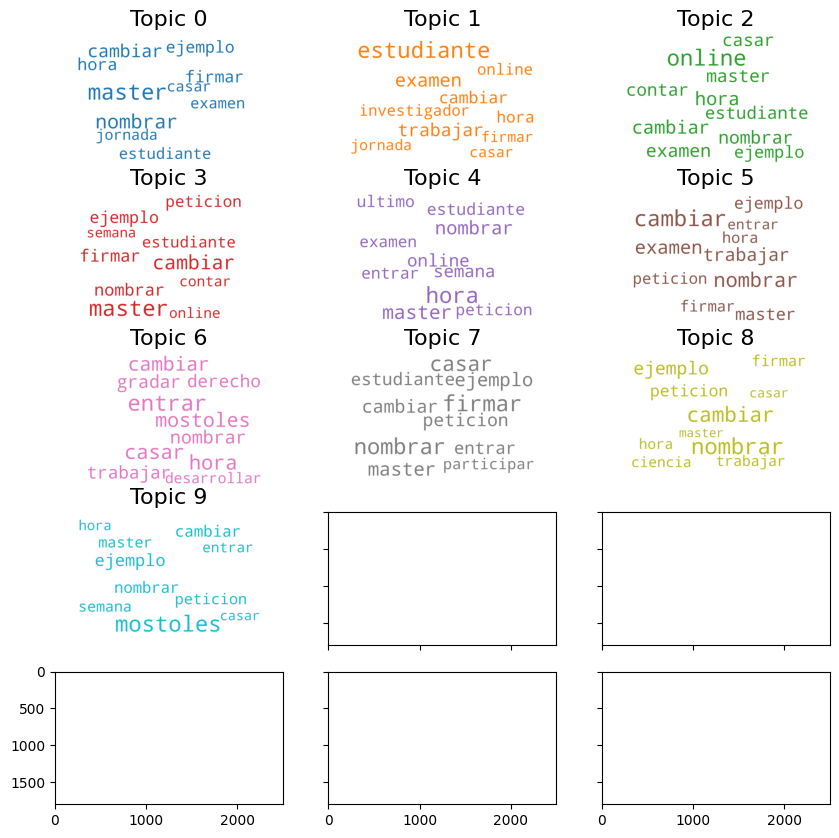

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords = stop_words,
                  background_color = 'white',
                  width = 2500,
                  height = 1800,
                  max_words = 10,
                  colormap = 'tab10',
                  color_func = lambda *args, **kwargs: cols[i],
                  prefer_horizontal = 1.0)

topics = model.show_topics(formatted = False)

fig, axes = plt.subplots(5, 3, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x = 0, y = 0)
plt.tight_layout()
plt.show()


In [ ]:

"""

PRE-PROCESS: 

0. Get the unduplicated / non-retweeted tweets. 


NON-TUNED PRE-PROCESSING STEPS:

1. Remove the hashtags, links and shares

2. Lowcase 

3. Remove punctuation 

4. Remove accents 

5. Remove numbers (TBC)

6. Lemmatise 

7. Make some corrections uncovered above


TUNED STEPS:

8. Remove stopwords (TBC properly) 

9. Remove short tweets 

10. Group by author and gridsearch best LDA hyperparameters.  

"""


# 1. Remove links, hashtags and mentions
# --------------------------------------

def hashtag(txt):
    
    # Remove hashtags
    result = ' '.join(word for word in txt.split(' ') if not word.startswith('#'))
    
    # Remove shares
    result = ' '.join(word for word in result.split(' ') if not word.startswith('@'))
    
    # Remove some jajajas
    result = ' '.join(word for word in result.split(' ') if 'jaja' not in word.lower())
    result = ' '.join(word for word in result.split(' ') if 'jj' not in word.lower())
    result = ' '.join(word for word in result.split(' ') if 'haha' not in word.lower())

    # Remove links
    result = re.sub(r'http\S+', '', result)

    # Further work with potential remainings
    result = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", result)
    result = re.sub(r'[¿“‘?’"„“<>,!"]', "", result)
    result = re.sub('!', "", result)
    
    return result

    
data['text'] = data['text'].apply(hashtag)


# 2. Lowcase 
# --------------------------------------

data['text'] = data['text'].apply(np.char.lower)



# 3. Remove punctuation from text
# --------------------------------------

from gensim.parsing.preprocessing import strip_punctuation
data['text'] = data['text'].apply(strip_punctuation)



# 4. Remove accents from text
# --------------------------------------

import unidecode
data['text'] = data['text'].apply(unidecode.unidecode)
data['text'] = data['text'].apply(gensim.utils.deaccent) # In case we apply both 



# 5. Remove numbers
# --------------------------------------

data['text'] = data['text'].str.replace('\d+', '')



# 6. Lemmatisation
# --------------------------------------
# The purpose of this code is to lemmatize (Convert to dictionary form) the words in each document, 
# keeping the same format

nlp = spacy.load('es_core_news_sm', exclude = ['derechos', 'expres', 'ademas', 'traves', 'adios'], disable = ['derechos', 'expres', 'ademas', 'traves', 'adios'])

def lemmatizer(text):  
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc])

data['lemmatized'] = data['text'].apply(lambda x: lemmatizer(x)) 



# 7. Further cleaning
# --------------------------------------

def corrector(text):     
    text = text.replace(' lumnos ', ' alumno ') 
    text = text.replace(' estudiante ', ' alumno ') # Synonims I think it's worth having them as the same word
    text = text.replace(' avda ', ' avenida ')
    text = text.replace(' info ', ' informacion ')
    text = text.replace(' uni ', ' universidad ')
    text = text.replace(' almerio ', ' almeria ')
    text = text.replace(' estudio ', ' estudiar ')
    text = text.replace(' cambier ', ' cambiar ')
    
    return text

data['lemmatized'] = data['lemmatized'].apply(corrector)

from gensim.parsing.preprocessing import strip_multiple_whitespaces
data['lemmatized'] = data['lemmatized'].apply(strip_multiple_whitespaces)



# 8. Stopwords work 
# --------------------------------------

# Find the list of stopwords

# Note that the removal depends on the library and will be part of each. 
stop_words = stopwords.words('spanish')
stop_words_extension = get_stop_words('es')
stop_words.extend(stop_words_extension)

# Remove accents from stopwords (I'll work with no accents anywhere, since we don't expect people to write always with accents) 
stop_words = [gensim.utils.deaccent(each_word) for each_word in stop_words]

stop_words.extend(['interesante', 'universidadjuancarlos', 'él', 'hala', 'juanca', 'reyjuancar', 'urjcritica', 'this', 'was', 'date', 'great', 'my', 'first', 'claro', 'queydondeestudiar2020', 'rey', 'juan', 'literalmente', 'universidadreyjuancarlo', 'universidadjuancarlos', 'lareyjuancarlos', 'universidadreyjuancarlos', 'universidadreyjuancarlo', 'urjc', 'gracia', 'gracias','ajjaj', 'xd', 'xdd', 'xdxd', 'Madrid', 'primero', 'segundo', 'tercero', 'cuarto', 'quinto', 'sexto', 'septimo', 'octavo', 't', 'a', 's', 'k', 'q', 'mas', 'tambien', 'ir', 'alla', 'cosa', 'iee', 'siquiera', 'in', 'the', 'of', 'ano', 'n', 'p', 'r', 'asi', 'coincidir', 'aa', 'decir', '¡', '¿', 'poder', 'podeis', 'estais', 'traves', 'alguno', 'buen', 'nosotrxs', 'bufff', 'buff', 'universitario', 'lol', 'omg', 'wtf', 'idk', 'fyi', 'tbh', 'lmao', 'asap', 'thanks', 'thank', 'thx', 
                'trav', 'bastante', 'muchisimo', 'muchisimos', 'muchisima', 'muchisimas', 'muchisimar', 'monton', 'habia', 'xe', 'jo', 'ops', 'ups', 'yupi', 'poca', 'poco', 'enhorabuena', 'incluso', 'igual', 'ahora', 'despu', 'pese', 'ser', 'cierto', 'haber', 'for', 'par', 'universidad', 'with', 'asimismo', 'carlos', 'universidad', 'iii', 'ser', 'entonces', 'madrid', 'tras', 'jo él', 'hacer', 'espán', 'noticia', 'as', 'periodico', 'diario', 'news', 'si', 'aca', 'mas', 'ademas', 'gracias', 'aqui', 'hola', 'saludos', 'hoy', 'co', 'bien', 'ver', 'dar', 'vosotrxs', 'wow', 'ahora', 'solo', 'todo', 'cualquier', 'cualquiera', 'pues', 'vez', 'mismo', 'evidentemente', 'uee', 'hey', 'hello', 'xvii', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', 'xii', 'xiii', 'xiv', 'xv', 'xvi', 'xviii', 'ixx', 'xx', 'xxi', 
                'parte', 'normalmente', 'mil', 'adio', 'millon', '!', 'yosoyurjc', 'haced', 'hacerte', 'mientras', 'menos', 'después', 'despues', 'dias', 'cuyo', 'cuya', 'of', '_', 'aun', 'nunca', 'siempre', 'muchisima', 'dia', 'algun', 'pon', 'sino', 'mejor', 'poca', 'peor', 'ano', 'nuevo', '200', '-', 'uee', 'href', 'uno', 'dos', 'tres', 'espán', 'medal él', 'desmontar él', 'jo él', 'joder', 'char él', 'queydondeestudiar', 'mer él', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez', 'veintena', 'doce', 'docena', 'trece', 'veitiuno', 'cien', 'decena', 'x2', '–', 'https', 'http', 'rt', 'm', 'uc', 'alguien', 'cada', 'latest', 'tmb', 'via', 'tal', 'etc', 'etcetera', 'traves', 'ma', 'ahi', 'aqui', 'alli', 'alla', 'so', 'if', 'mmm', 'hmm', 'ja', 'cuidadosamente', 'quizas', 'quiza', 'nada', 'nunca', 'probablemente', 'mismisimo', 'totalmente', 'completamente'])

stop_words.extend(['informacion', 'titulo', 'alumno', 'estudiar', 'profesor', 'primerisimo', 'adema', 'yomequedoencasa'])

# Frequent words that add litle meaning: Hyperparameter in gridsearch
extras = ['seguro', 'realizar', 'titulo', 'clase', 'tener', 'necesitar', 'querer', 'abrir', 'agarrar', 'andar', 'caminar', 'buscar', 'caer', 'conocer', 'saber', 'hablar', 'tener', 'tomar', 'poner', 'dar', 'ir', 'decir', 'estar', 'ser', 'vivir', 'oir', 'poner', 'traer', 'sentir', 'ver', 'mirar', 'llegar', 'llevar', 'entender', 'oler', 'salir', 'comprender', 'rayar', 'tener', 'flipar', 'putear', 'darle', 'saber', 'pasar', 'poner', 'esperar', 'dejar', 'parecer', 'salir', 'seguir', 'creer', 'opinar', 'informacion', 'alumno']


# Further code saved

In [ ]:
# # Code to check quicly the possible quality of the application. 

# """ 

# This code reflects:

# You will have indicated the step by numeric definition (1., 2., etc) in a # comment.

# The hipermarameters that are adjusted will be commented (#) in the same line they're used. 

# """

# from gensim.corpora import Dictionary
# from gensim.models.ldamulticore import LdaMulticore
# from gensim.models.coherencemodel import CoherenceModel
# import copy

# # Function that will remove the stopwords indicated by the preprocessing hp i_stopwords
# def remove_stopwords(texts, stop_words_new):
#     return [[word for word in simple_preprocess(str(doc)) if word not in stop_words_new] for doc in texts]


# # Function replicating sklearn pipeline gridsearch
# def gensim_gridsearch(data):
    
#     """
#     HYPERPARAMETER CHOICE PROCESS: 
    
#     Best Model: Model that makes more sense and groups the data well. This is something that is done by looking ate
#     the results of the model, but is correlated with Likelihood/Pplexity and Coherence Score gain functions. So, these
#     are utilised to filter out LDA (Not preprocessing) hp values that are unlikely to reflect well the hidden topics. 
    
#     The objective is to break the problem into first break it by preprocessing decision, and for each reduce the 
#     k topics gridsearch based on the coherence score. 
    
#     Once this is sorted, a more thorough gridsearch will be undertaken to truly identify the best values of alpha and 
#     beta, and which pipeline generates the best quality insight. 
    
#     """
    
#     coherence_values = []
#     model_list = []
#     parameters = pd.DataFrame(columns = ['i_stopwords', 'cutoff', 'alpha', 'eta', 'no_below', 'no_above', 'num_topics'])
    
#     # I would probably remove the symetric stuff... or give a value to it to be able to plot the results 
#     for i_stopwords in ['yes']: # Preprocessing HP1: Consider extra stopverbs: Yes/No (Per a mi es un yes)
#         for cutoff in [5]: # Preprocessing  HP2: 
#             for no_below in [4]: # Preprocessing  HP3: Minimum of the tweets for a word to be considered
#                 for no_above in [1]:  # Preprocessing  HP4: Maximum % if tweet for a word to be considered  
#                     for alpha in [0.25, 0.5, 0.75]: # LDA HP Alpha: Prior 
#                         for eta in [0.25, 0.5, 0.75]: # LDA HP Eta: Prior
#                             for num_topics in range(2, 5): # LDA HP K: Number of topics
                                
#                                 parameters.loc[-1] = [i_stopwords, cutoff, alpha, eta, no_below, no_above, num_topics]
#                                 parameters.index = parameters.index + 1

#                                 tokens = data
#                                 tokens['tokens'] = tokens.lemmatized.values.tolist()
                                
#                                 def sent_to_words(sentences):
#                                     for sentence in sentences:
#                                         yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))
                                
#                                 tokens['tokens'] = list(sent_to_words(tokens['tokens']))
                                
#                                 # Remove lvl2 stopwords: 
#                                 stop_words_new = copy.deepcopy(stop_words)
                                
#                                 if i_stopwords == 'yes':     
#                                     stop_words_new.extend(extras)
                                    
#                                 tokens['tokens'] = remove_stopwords(tokens['tokens'], stop_words_new)
                                
#                                 # Remove documents with 3 words or less of length 4:
#                                 tokens = tokens[tokens['tokens'].map(len) > cutoff]
                                
#                                 # Group by author
#                                 tokens['tokens'] = tokens['tokens'].apply(lambda x: ' '.join(x))
#                                 tokens['tokens'].astype(str)
#                                 author = tokens.groupby('author_id')['tokens'].agg(lambda x: ' '.join(map(str, x))).reset_index()
#                                 author['tokens'] = list(sent_to_words(author['tokens']))
                                
#                                 # Filter extremes
#                                 id2word = Dictionary(author['tokens'], prune_at = 1000000)
#                                 id2word.filter_extremes(no_below = no_below, no_above = no_above, keep_n = None)
                                
#                                 # Create Corpus
#                                 texts = list(sent_to_words(author['tokens']))
                                
#                                 # Term Document Frequency
#                                 corpus = [id2word.doc2bow(text) for text in texts]
                                
#                                 model = LdaMulticore(corpus = corpus, eta = eta, alpha = alpha, num_topics = num_topics, id2word = id2word, iterations = 40, random_state = 10,
#                                                     workers = 5)
                                
#                                 model_list.append(model)
#                                 coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = id2word, coherence = 'c_v')
#                                 coherence_values.append(coherencemodel.get_coherence())
                                
#                                 print(i_stopwords, cutoff, alpha, eta, no_below, no_above, num_topics)
                               
        
#     parameters['Score'] = coherence_values
#     parameters.to_csv("gridsearch_gensim_2.csv",  index = False)

#     return model_list, coherence_values, parameters
